In [1]:
import torch
import phate
import scprep
import numpy as np
import sys
import torch.distributions as dist
import matplotlib.pyplot as plt

In [23]:

u = torch.tensor(1/11)
u = u.repeat(11)
u.sum()

tensor(1.0000)

In [2]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=150)

In [3]:
print(tree_data.shape)

(1200, 10)


In [4]:
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 1200 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.06 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.88 seconds.
Calculated PHATE in 1.21 seconds.


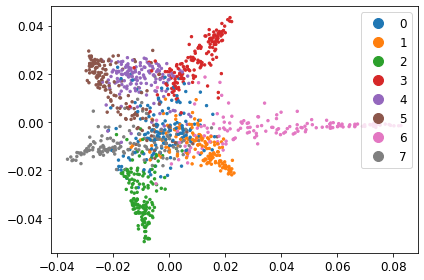

In [5]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)

In [6]:
X = torch.tensor(tree_data, requires_grad=True)

In [7]:
n = 200

In [8]:
random_indices = np.random.randint(tree_data.shape[0], size=n)

In [9]:
phate_operator = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate = phate_operator.fit_transform(tree_data[random_indices])

Calculating PHATE...
  Running PHATE on 200 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.07 seconds.


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 14 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


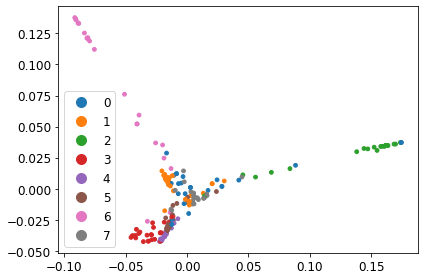

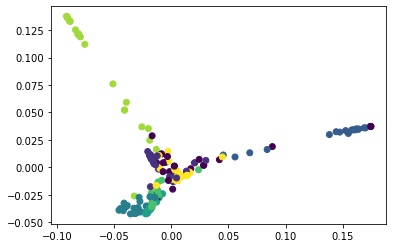

In [10]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters[random_indices])

plt.figure()
plt.scatter(tree_phate[:,0],tree_phate[:,1],  c=tree_clusters[random_indices] )

In [53]:
x = torch.zeros(10)
rint = torch.randint(10,(1,1)).squeeze()
x[rint] =1


In [11]:
%%time
def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")
    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)  
    kernel = gaussian_kernel(dists)
    D_flat = kernel.sum(axis=0)
    D = torch.diagflat(D_flat ** -0.5)
    p = (D) @ kernel @ (D)
    L, Q = torch.linalg.eigh(p)
    assert torch.allclose(Q @ torch.diagflat(L) @ Q.T,p)
    # Truncate to keep gradients okay
    mask = L < 0.1
    L = L[~mask]
    Q = Q[:, ~mask]
    pt = torch.diagflat(D_flat ** -0.5) @ Q @ torch.diagflat(torch.pow(L, t)) @ Q.T @ torch.diagflat(D_flat ** 0.5)
    #print(pt)
    
    dim = pt.size()[0]
    x = torch.zeros(dim)
    rint = torch.randint(dim,(1,1)).squeeze()
    #print(rint)
    x[9] = 1
    #x = torch.ones(dim)
    log_p = torch.log(pt @ x.double())


    return log_p

#log_P = torch_phate(X[random_indices])
#assert torch.abs(torch.exp(log_P[0]).sum() - 1) < 1e-2

def torch_phate_fixed_data(bandwidth, t):
    return torch_phate(X[random_indices], bandwidth=bandwidth, t=t)

def calc_fischer(bandwidth, t):
    bandwidth = torch.tensor(bandwidth, requires_grad=True, dtype=torch.float64)
    t = torch.tensor(t, requires_grad=True, dtype=torch.float64)
    log_P = torch_phate_fixed_data(bandwidth, t)
    J = torch.autograd.functional.jacobian(torch_phate_fixed_data, (bandwidth, t))
    # shape: N_output [N x N], input [N x D]
    J = torch.stack(J)
    #fischer = J.unsqueeze(1) * J.unsqueeze(0) * torch.exp(log_P)
    #fischer = fischer.sum(axis=-1).mean(axis=-1)
    
    fischer = torch.zeros((2,2))
    for i in range(J.shape[0]):
        for j in range(J.shape[0]):
            hold = J[i,:] * J[j,:] * torch.exp(log_P)
            fischer[i,j] = hold.sum()


    return fischer

#calc_fischer(100, 7)

def local_volume(bandwidth, t):
    return torch.sqrt(torch.abs(torch.linalg.det(calc_fischer(bandwidth, t))))

#local_volume(100, 7)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 18.6 µs


In [76]:
print(X[random_indices].mean(0))
print(X[random_indices].shape)

tensor([ 0.4568,  0.7369,  4.4295,  2.7893, -0.4663,  4.0529, -2.2339, -0.1881,
        -1.7992, -5.5448], dtype=torch.float64, grad_fn=<MeanBackward1>)
torch.Size([200, 10])


In [12]:
fsdiracs = []

n = 200
#Picking dense vs sparse nodes
random_indices = np.random.randint(tree_data.shape[0], size=n)
data = X[random_indices].detach().numpy()
distind = np.argsort(np.linalg.norm((data - data.mean(0)),axis=1))

for i in range(2):
    
    #n = n + 2
    #a = torch.randint(n,(1,1)).squeeze()
    
    #dense region
    a = distind[0]
    
    #sparse region
    if i > 0:
        a = distind[-1]
        
    print(a)
    
    
    def torch_phate_fixed_data(bandwidth, t):
        return torch_phate(X[random_indices], bandwidth=bandwidth, t=t)
    

    def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
        dists = torch.norm(X[:, None] - X, dim=2, p="fro")
        def gaussian_kernel(x):
            return torch.exp(-(dists**2) / bandwidth)  
        kernel = gaussian_kernel(dists)
        D_flat = kernel.sum(axis=0)
        D = torch.diagflat(D_flat ** -0.5)
        p = (D) @ kernel @ (D)
        L, Q = torch.linalg.eigh(p)
        assert torch.allclose(Q @ torch.diagflat(L) @ Q.T,p)
        # Truncate to keep gradients okay
        mask = L < 0.1
        L = L[~mask]
        Q = Q[:, ~mask]
        pt = torch.diagflat(D_flat ** -0.5) @ Q @ torch.diagflat(torch.pow(L, t)) @ Q.T @ torch.diagflat(D_flat ** 0.5)
        #print(pt)

        x = torch.zeros(n)
        x[a] = 1
        #x = torch.ones(dim)
  
        
        log_p = torch.log(x.double() @ pt)


        return log_p



    bandwidths = np.linspace(60, 150, 15)
    ts = np.linspace(4, 8, 15)
    #bandwidths = np.linspace(50, 100, 50)
    #ts = np.linspace(1, 15, 50)
    bv, tv = np.meshgrid(bandwidths, ts)

    fs = []
    for b, t in zip(bv.flatten(), tv.flatten()):
        fs.append(calc_fischer(b, t))
    fs = torch.stack(fs)
    a = a + 1
    fsdiracs.append(fs)

130
88


In [ ]:
volumes = torch.sqrt(torch.abs(torch.linalg.det(fs)))

In [13]:
nv = []
print(len(fsdiracs))
for i in range(2):
    nv.append(torch.sqrt(torch.abs(torch.linalg.det(fsdiracs[i]))))

2


In [14]:
coords = (np.array([bv.flatten(), tv.flatten()]).T)

In [17]:
import matplotlib.pyplot as plt
plt.scatter(coords[:,0], coords[:,1], c=volumes.detach().numpy())
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.title("Volume Grid")

NameError: name 'volumes' is not defined

'\nplt.subplot(223)\nplt.title("Volume grid: Dirac 3")\nplt.pcolormesh(bandwidths, ts, nv[2].detach().numpy().reshape(bv.shape))\nplt.xlabel("bandwidth")\nplt.ylabel("t")\nplt.colorbar()\n\nplt.subplot(224)\nplt.title("Volume grid: Dirac 4")\nplt.pcolormesh(bandwidths, ts, nv[3].detach().numpy().reshape(bv.shape))\nplt.xlabel("bandwidth")\nplt.ylabel("t")\nplt.colorbar()\n\n'

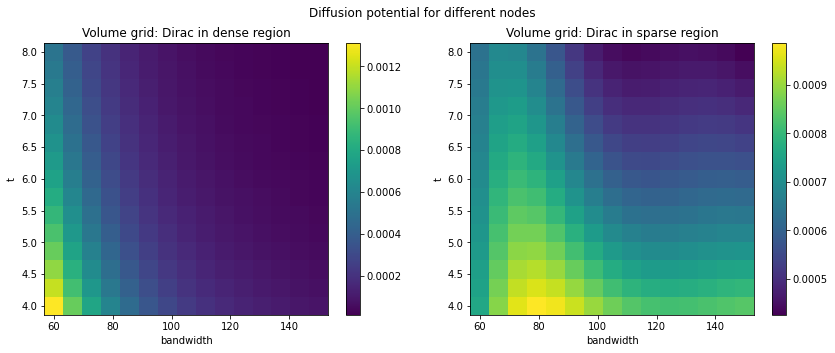

In [22]:


plt.figure(figsize=(14,5))
plt.suptitle("Diffusion potential for different nodes")
plt.subplot(121)
plt.title("Volume grid: Dirac in dense region")
plt.pcolormesh(bandwidths, ts, nv[0].detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.colorbar()

plt.subplot(122)
plt.title("Volume grid: Dirac in sparse region")
plt.pcolormesh(bandwidths, ts, nv[1].detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.colorbar()


"""
plt.subplot(223)
plt.title("Volume grid: Dirac 3")
plt.pcolormesh(bandwidths, ts, nv[2].detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.colorbar()

plt.subplot(224)
plt.title("Volume grid: Dirac 4")
plt.pcolormesh(bandwidths, ts, nv[3].detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.colorbar()

"""


Calculating PHATE...
  Running PHATE on 200 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.07 seconds.


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 17 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


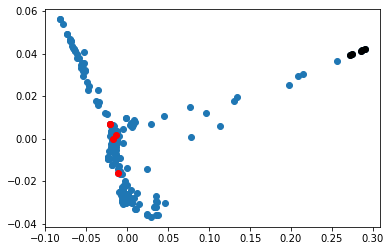

In [21]:

phate_operator = phate.PHATE(knn=5, decay=20, t=150, random_state=42)
tree_phate = phate_operator.fit_transform(tree_data[random_indices])
plt.scatter(tree_phate[:,0],tree_phate[:,1])
plt.scatter(tree_phate[distind[:5],0],tree_phate[distind[:5],1],c='red')
plt.scatter(tree_phate[distind[-5:],0],tree_phate[distind[-5:],1],c='black')


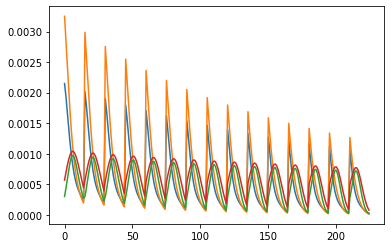

In [65]:
plt.plot(nv[0].detach().numpy())
plt.plot(nv[1].detach().numpy())
plt.plot(nv[2].detach().numpy())
plt.plot(nv[3].detach().numpy())

In [25]:
print(n)

200


# Trying for uniform distribution

In [26]:


%%time
def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")
    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)  
    kernel = gaussian_kernel(dists)
    D_flat = kernel.sum(axis=0)
    D = torch.diagflat(D_flat ** -0.5)
    p = (D) @ kernel @ (D)
    L, Q = torch.linalg.eigh(p)
    assert torch.allclose(Q @ torch.diagflat(L) @ Q.T,p)
    # Truncate to keep gradients okay
    mask = L < 0.1
    L = L[~mask]
    Q = Q[:, ~mask]
    pt = torch.diagflat(D_flat ** -0.5) @ Q @ torch.diagflat(torch.pow(L, t)) @ Q.T @ torch.diagflat(D_flat ** 0.5)
    #print(pt)
    
    u = torch.tensor(1/n)
    u = u.repeat(n)
    log_p = torch.log(u.double() @ pt)


    return log_p


bandwidths = np.linspace(60, 150, 15)
ts = np.linspace(4, 8, 15)
#bandwidths = np.linspace(50, 100, 50)
#ts = np.linspace(1, 15, 50)
bv, tv = np.meshgrid(bandwidths, ts)

fs = []
for b, t in zip(bv.flatten(), tv.flatten()):
    fs.append(calc_fischer(b, t))
fs = torch.stack(fs)

volumes = torch.sqrt(torch.abs(torch.linalg.det(fs)))
coords = (np.array([bv.flatten(), tv.flatten()]).T)

CPU times: user 7min 33s, sys: 1.42 s, total: 7min 35s
Wall time: 1min 16s


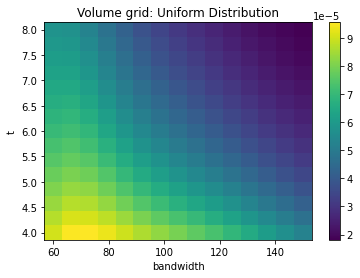

In [29]:

plt.figure()
plt.title("Volume grid: Uniform Distribution")
plt.pcolormesh(bandwidths, ts, volumes.detach().numpy().reshape(bv.shape))
plt.xlabel("bandwidth")
plt.ylabel("t")
plt.colorbar()
